## Machine Learning 프로젝트 수행을 위한 코드 구조화

`(분류, 회귀 Task)`

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
!pip install optuna
import optuna

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)

In [4]:
# 데이터를 불러옵니다.
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/패캠 머신러닝 실습/ch6.실습/train.csv.zip")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/패캠 머신러닝 실습/ch6.실습/test.csv.zip")
train

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [6]:
# X0 ~ 8까지 object 
dtype_train = train.dtypes.reset_index()
dtype_train.loc[:10,:] 

,index,0
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


In [7]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# train 결측치 없음
train[train.isnull().any(axis = 1)]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [9]:
# test 결측치 없음
test[test.isnull().any(axis = 1)]

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


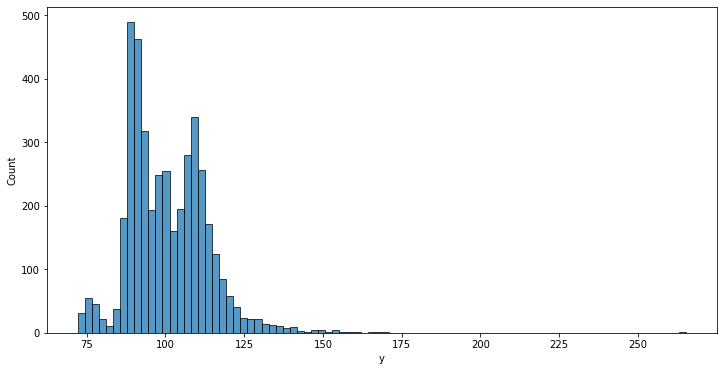

In [10]:
# y 분포
plt.figure(figsize = (12, 6))
sns.histplot(data = train, x = 'y')
plt.show()

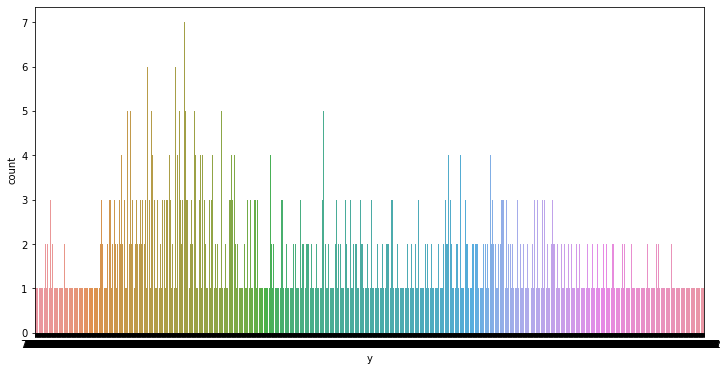

In [11]:
plt.figure(figsize = (12, 6))
sns.countplot(data = train, x = 'y')
plt.show()

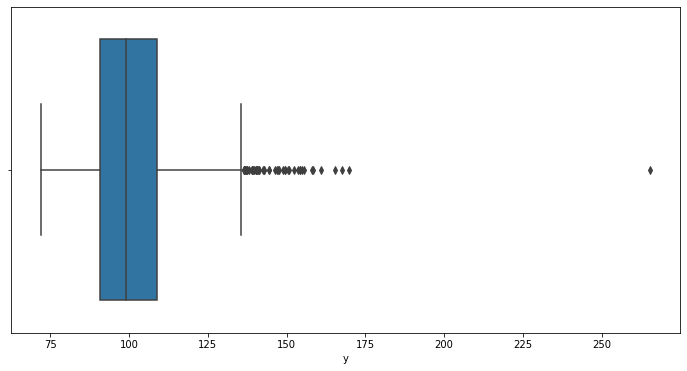

In [12]:
# oulier 제거 필요해보임
plt.figure(figsize = (12, 6))
sns.boxplot(data = train, x = 'y')
plt.show()

In [13]:
# 평균값 확인
level_1q = train['y'].quantile(0.25)
level_3q = train['y'].quantile(0.75)
IQR = level_3q - level_1q
level_3q + (1.5 * IQR)

136.29500000000002

In [14]:
# 이상치 제거 
outlier = train.loc[train.y > 136] 
train = train.drop(index = outlier.index)

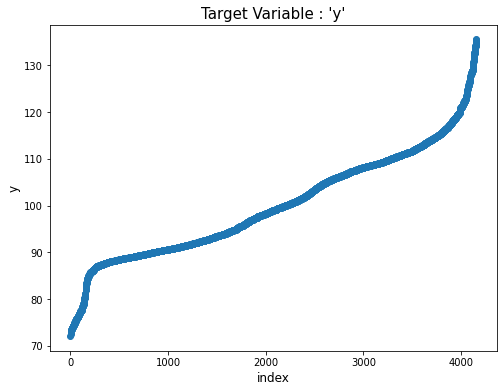

In [15]:
plt.figure(figsize = (8,6))
plt.scatter(range(train.shape[0]), np.sort(train.y.values))
plt.xlabel('index', fontsize = 12)
plt.ylabel('y',fontsize = 12)
plt.title("Target Variable : 'y'", fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


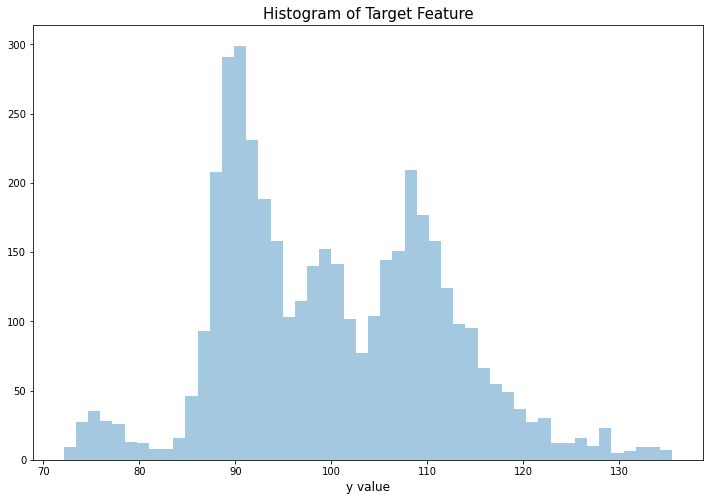

In [16]:
ulimit = 180
train['y'].loc[train['y'] > ulimit] = ulimit

plt.figure(figsize = (12, 8))
sns.distplot(train.y.values, bins = 50, kde = False)
plt.xlabel('y value', fontsize = 12)
plt.title("Histogram of Target Feature", fontsize = 15)
plt.show()

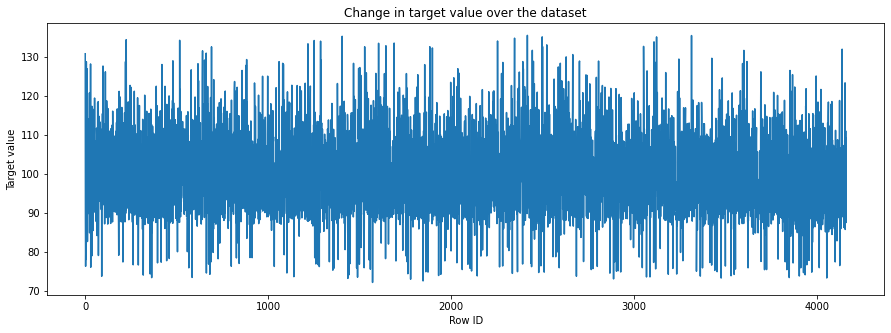

In [17]:
y_train = train['y'].values

plt.figure(figsize = (15, 5))
plt.plot(y_train)
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset')
plt.show()

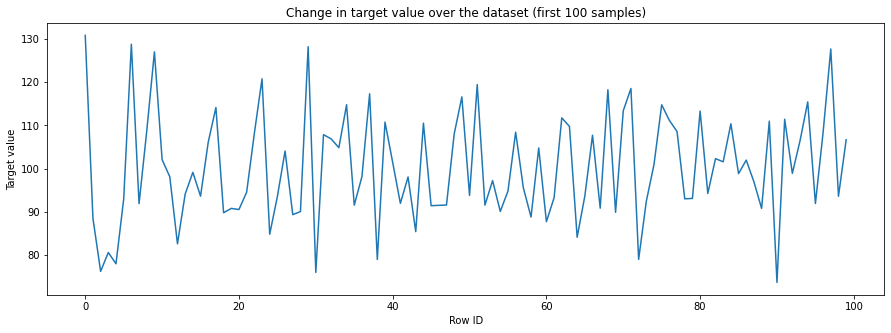

In [18]:
plt.figure(figsize = (15, 5))
plt.plot(y_train[:100])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset (first 100 samples)')
print()

In [19]:
# 특징 
# 1. 결측치 - 없음
# 2. dtype이 object인 column : X0 ~ X8 
# -> [Ordinal Encoding vs One-Hot Encoding]
# -> binary feature들 중에 0만 가지고 있는 column 존재 
# 3. target distribution -> train data에 180 넘는 데이터 하나 있음. outlier로 제거

#### 특징 
- 1. 결측치 - 없음
- 2. dtype이 object인 column : X0 ~ X8 
  
  : [Ordinal Encoding vs One-Hot Encoding]
 
  : binary feature들 중에 0만 가지고 있는 column 존재 
- 3. target distribution 
 
 : train data에 180 넘는 데이터 하나 있음. outlier로 제거

### 3. 전처리

#### 결측치 처리

#### feature 구분
- X0 ~ X8 : Categorical feature
- other feature : binary feature(0/1)

In [20]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
categorical_features = train.columns[2:10]
categorical_features

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')

In [21]:
temp = train.columns[10:]
temp

Index(['X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=368)

In [22]:
card1 = train.columns[train.nunique() == 1]
card1

Index(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293',
       'X297', 'X330', 'X339', 'X347'],
      dtype='object')

In [23]:
# dtype이 object인 변수들 처리
binary_features = np.setdiff1d(temp, card1)
print("%d features - %d features = %d binary features" % (len(temp), len(card1), len(binary_features)))

368 features - 13 features = 355 binary features


#### feature engineering

In [26]:
# feature engineering을 위해 tempX, y 생성
total = pd.concat([train, test])
split_point = len(train)
total_OHE = pd.get_dummies(data=total, columns= categorical_features)
y = train.y
tempX = total_OHE.drop(columns=["ID", "y"])
tempX = tempX.drop(columns=card1)
trainX = tempX[:split_point]
testX = tempX[split_point:]
print(trainX.shape, testX.shape, y.shape)

(4159, 565) (4209, 565) (4159,)


In [27]:
trainX

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4206,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4207,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [28]:
testX

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4206,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4207,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


#### 다중공선성 처리

In [29]:
# 상관계수가 threshold(e.g. 0.8)를 넘기는 feature들을 제거합니다.
# threshold : 다중공선성 제거할 column 고르는 기준 값 [0, 1]
# X : feaure matrix 
def remove_collinearity(X, threshoId):

 corr = X.corr()
 candidate_cols = []

 for x in corr.iterrows():
    idx, row = x[0], x[1] # decoupling tuple -> 해당 row는 이미 처리가 되어있음 
    if idx in candidate_cols:
        continue          # print(row[row > 0.7].index[1:])
    candidates = row[row > threshoId].index[1:]

    # threshoId 넘는 column 있다면 
    if len(candidates) != 0:
       for col in candidates:
           candidate_cols.append(col)

 return candidate_cols

In [30]:
def find_feature_importance(X, model, show_plot):

    feat_names = X.columns.values
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(12,12))
    plt.title("Feature importances")
    plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
    plt.xlim([-1, len(indices)])
    plt.show()
    
    important_features = X.columns[importances >= 0.005]
    return important_features

#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [31]:
# PCA 적용
def apply_PCA(X, show_plot):
    from sklearn.decomposition import PCA  # trianing data와 test data 모두 PCA 이용하여 차원 감소 

    pca = PCA(n_components=0.9) # PCA(n_components=6)
    pca_09 = pca.fit(X) # 학습 및 변환
    reduced_X = pca_09.transform(X)
    print(reduced_X.shape)

    if show_plot:
       labels = [f"PC{x}" for x in range(1, reduced_X.shape[1]+1)]
       pca_09_variance = np.round(pca_09.explained_variance_ratio_.cumsum()*100, decimals=1)
       plt.figure(figsize=(25,5))
       plt.bar(x=range(1, len(pca_09_variance)+1), height=pca_09_variance, tick_label=labels)

       plt.xticks(rotation=90, color='indigo', size=15)
       plt.yticks(rotation=0, color='indigo', size=15)
       plt.title('Scree Plot',color='tab:orange', fontsize=25)
       plt.xlabel('Principal Components', {'color': 'tab:orange', 'fontsize':15})
       plt.ylabel('Cumulative percentage of explained variance ', {'color': 'tab:orange', 'fontsize':15})
       plt.show()
        
       X_train_pca_train = pd.DataFrame(reduced_X, columns=labels)
       display(X_train_pca_train)

    return pca_09, X_train_pca_train

In [32]:
# PCA 적용
if feature_reducing == "correlation":
    threshold = 0.7
    correlated_features = remove_collinearity(trainX, threshold)
    correlated_features = set(correlated_features) # 중복 제거
    print("%d Correlation features over %.2f" % (len(correlated_features), threshold))
    
    X = trainX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    show_plot = True
    model = RandomForestRegressor(max_features="sqrt", n_jobs=-1, random_state=0xC0FFEE)
    model.fit(trainX, y)
    important_features = find_feature_importance(trainX, model, show_plot)
    X = trainX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    show_plot = True
    pca_model, X = apply_PCA(trainX, show_plot)
    print(X.shape)

### 4. 학습 데이터 분할

In [34]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
X = trainX
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0xC0FFEE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3743, 565) (416, 565) (3743,) (416,)


### 5. 학습 및 평가

In [35]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 2,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

model = LGBMRegressor(**param_grid)

In [36]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...


LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.0025, max_bin=20,
              metric='mae', min_data=500, min_hessian=0.05, num_leaves=512,
              objective='regression', sub_feature=0.345, verbose=2)

In [37]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
from sklearn.metrics import r2_score
evaluation_metric = r2_score

In [38]:
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.1614
Test Score : 0.1527


### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [39]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Estimator :  LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.003, max_bin=20,
              max_depth=8, metric='mae', min_data=500, min_hessian=0.05,
              n_estimators=500, num_leaves=256, objective='regression',
              sub_feature=0.345, verbose=-1)


In [40]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(X_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

Prediction with Best Estimator
Train MAE Score : 0.4867
Test MAE Score : 0.4701


In [41]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

Performance Gain
in train :  -0.3253857087071451
in test :  -0.31730230537212567


> optuna를 사용해봅시다 !

In [47]:
# For Regression

def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2'])
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=0xC0FFEE)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [48]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

rf_study = optuna.create_study(study_name="RF", direction="maximize") # regression task에서 R^2를 최대화!
rf_study.optimize(opt_func, n_trials=15)

[I 2022-06-18 13:44:44,784] A new study created in memory with name: RF
[I 2022-06-18 13:44:46,617] Trial 0 finished with value: 0.5070846035792843 and parameters: {'n_estimators': 50, 'max_depth': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.5070846035792843.
[I 2022-06-18 13:44:58,690] Trial 1 finished with value: 0.6065393093014133 and parameters: {'n_estimators': 188, 'max_depth': 27, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6065393093014133.
[I 2022-06-18 13:45:56,025] Trial 2 finished with value: 0.6095662225697321 and parameters: {'n_estimators': 105, 'max_depth': 24, 'max_features': 'auto'}. Best is trial 2 with value: 0.6095662225697321.
[I 2022-06-18 13:46:09,535] Trial 3 finished with value: 0.6215116830573658 and parameters: {'n_estimators': 51, 'max_depth': 15, 'max_features': 'auto'}. Best is trial 3 with value: 0.6215116830573658.
[I 2022-06-18 13:46:31,276] Trial 4 finished with value: 0.6062171475329403 and parameters: {'n_estimators': 57, 'm

In [49]:
# optuna가 시도했던 모든 실험 관련 데이터
rf_study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_n_estimators,state
0,0,0.507085,2022-06-18 13:44:44.790880,2022-06-18 13:44:46.616860,0 days 00:00:01.825980,8,log2,50,COMPLETE
1,1,0.606539,2022-06-18 13:44:46.621832,2022-06-18 13:44:58.689898,0 days 00:00:12.068066,27,sqrt,188,COMPLETE
2,2,0.609566,2022-06-18 13:44:58.693821,2022-06-18 13:45:56.025387,0 days 00:00:57.331566,24,auto,105,COMPLETE
3,3,0.621512,2022-06-18 13:45:56.028984,2022-06-18 13:46:09.535098,0 days 00:00:13.506114,15,auto,51,COMPLETE
4,4,0.606217,2022-06-18 13:46:09.538495,2022-06-18 13:46:31.276562,0 days 00:00:21.738067,25,auto,57,COMPLETE
5,5,0.582345,2022-06-18 13:46:31.280075,2022-06-18 13:46:33.694630,0 days 00:00:02.414555,15,log2,64,COMPLETE
6,6,0.633124,2022-06-18 13:46:33.697903,2022-06-18 13:47:07.862281,0 days 00:00:34.164378,11,auto,174,COMPLETE
7,7,0.591808,2022-06-18 13:47:07.869661,2022-06-18 13:47:13.494930,0 days 00:00:05.625269,23,log2,95,COMPLETE
8,8,0.608925,2022-06-18 13:47:13.497956,2022-06-18 13:48:29.631695,0 days 00:01:16.133739,27,auto,200,COMPLETE
9,9,0.608594,2022-06-18 13:48:29.635208,2022-06-18 13:49:41.587571,0 days 00:01:11.952363,26,auto,183,COMPLETE


In [50]:
print("Best Score: %.4f" % rf_study.best_value) # best score 출력
print("Best params: ", rf_study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.6331
Best params:  {'n_estimators': 174, 'max_depth': 11, 'max_features': 'auto'}


In [51]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(rf_study)

In [52]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(rf_study)

### 7. 테스트 및 제출 파일 생성

In [53]:
model = RandomForestRegressor(n_estimators=rf_study.best_trial.params["n_estimators"],
                                 max_depth=rf_study.best_trial.params["max_depth"],
                                 max_features=rf_study.best_trial.params["max_features"])

model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

array([111.79194394, 102.7712979 ,  93.32728622, 107.31874107,
       102.57159188, 102.96248579,  93.76919821,  93.3244198 ,
        91.49296229,  93.96909149,  93.62583183,  93.5778544 ,
        93.74433487, 102.24417529,  96.20117336,  93.12565349,
        93.56224242,  93.63323474,  93.43102079, 111.06822548,
        92.85881129, 111.2999605 , 102.07093862,  77.11504882,
        91.43515198, 111.35392062, 102.92758916,  94.53095332,
        93.27860435,  93.43415032, 102.52190619,  94.27947475,
        95.90418291,  94.95899144,  80.04453639,  76.58639   ,
       110.51559644, 112.20400228,  94.12846438,  93.6888289 ,
        94.99473554, 111.08251132,  93.8804282 , 109.34402595,
        92.09937707,  93.80821621,  93.60377832, 110.40867503,
       102.17198629,  95.53136848, 111.54523063, 102.32786935,
       110.58025643,  93.43115522, 111.40085273, 111.34665304,
        93.89049681,  93.72385298,  93.23009119, 110.97482975,
        92.90989671, 112.98325424,  77.30089332,  94.01

In [54]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
1689,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1984,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1741,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
526,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1624,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1061,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1318,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
submission = pd.DataFrame() # submission을 생성합니다.
submission

""


In [56]:
submission.reset_index(drop=True).to_csv("submission.csv", index=False)